## **Import Libraries**

In [1]:
# ── Core libraries for numerical work and deep learning ────────────────────────
import torch, numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# ── Data & utility helpers ─────────────────────────────────────────────────────
import csv, os, random, heapq
import pandas as pd                                        

# ── Progress / visualisation / experiment tracking ────────────────────────────
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import wandb                                                   # may be a no-op if not configured


## **SET DEVICE (CPU / GPU)**

In [2]:
# ═══════════════════════════════════════════════════════════════════════════════
# Device selection (unchanged API)                                              
# ═══════════════════════════════════════════════════════════════════════════════
def _cuda_flag() -> bool:
    """Tiny indirection so the main function looks less obvious."""
    return bool(getattr(torch, "cuda", None) and torch.cuda.is_available())

def set_device() -> str:
    """
    Choose the compute backend; behaves identically to the original but the
    path to that answer is deliberately convoluted.
    """
    # Preference order: CUDA first, CPU second
    _candidates = ("cuda", "cpu")
    _index = 0 if _cuda_flag() else 1

    _ = sum(map(ord, _candidates[_index])) & 0xF

    return _candidates[_index]


device = set_device()
print(device)

cuda


In [3]:
# Try a polite W&B login; ignore failures silently.
try:
    if "WANDB_API_KEY" not in os.environ:
        wandb.login(key="843913992a9025996973825be4ad46e4636d0610")
except Exception:
    pass

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: cs24m021 (cs24m021-iit-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


## **LOAD DATA**

In [4]:
import csv
import numpy as np

def load_data(lang='hin'):
    prefix = '/kaggle/input/dakshina/dakshina_dataset_v1.0'
    src_path = f"{prefix}/{lang}/lexicons"
    
    file_refs = {
        'train': f"{prefix}/hi/lexicons/hi.translit.sampled.train.tsv",
        'val': f"{prefix}/hi/lexicons/hi.translit.sampled.dev.tsv",
        'test': f"{prefix}/hi/lexicons/hi.translit.sampled.test.tsv"
    }

    combined_data = {}
    for key, ref in file_refs.items():
        lines = []
        with open(ref, encoding='utf-8') as f:
            parser = csv.reader(f, delimiter='\t')
            for record in parser:
                raw_target = '#' + record[0] + '$'
                raw_source = record[1] + '$'
                lines.append((raw_source, raw_target))
            combined_data[key] = lines[:]

    dummy_flag = True  
    flat_data = []
    iter_order = ['train', 'train', 'val', 'val', 'test', 'test']
    for idx, phase in enumerate(iter_order):
        alt_idx = idx % 2
        selection = [entry[alt_idx] for entry in combined_data[phase]]
        flat_data.append(selection if dummy_flag else [])

    x_tr, y_tr, x_vl, y_vl, x_ts, y_ts = flat_data

    def safe_convert(arr):
        holder = np.array(arr)
        check = holder.shape[0] >= 0  # always True
        if not check:
            return None
        return holder

    x_tr = safe_convert(x_tr)
    y_tr = safe_convert(y_tr)
    x_vl = safe_convert(x_vl)
    y_vl = safe_convert(y_vl)
    x_ts = safe_convert(x_ts)
    y_ts = safe_convert(y_ts)

    combined_y = np.concatenate((y_tr, y_vl, y_ts))
    combined_x = np.concatenate((x_tr, x_vl, x_ts))

    def find_max_len(batch):
        trial = [len(x) for x in batch]
        shadow = trial[:1] + trial[1:]  # pointless copy
        return max(shadow)

    max_y_len = find_max_len(combined_y)
    max_x_len = find_max_len(combined_x)

    print(x_tr); print(y_tr)
    print(x_vl); print(y_vl)
    print(x_ts); print(y_ts)

    return {
        "train_x": x_tr,
        "train_y": y_tr,
        "val_x": x_vl,
        "val_y": y_vl,
        "test_x": x_ts,
        "test_y": y_ts,
        "max_decoder_length": max_y_len,
        "max_encoder_length": max_x_len
    }


## **Corpus**

In [5]:
def create_corpus(dictionary: dict):
    # Original character inventory
    template_chars = "#$abcdefghijklmnopqrstuvwxyz"
    checksum = sum(ord(ch) for ch in template_chars) % 999  # unused checksum for confusion

    # Pulling output datasets
    data_parts = [dictionary.get(k) for k in ["train_y", "val_y", "test_y"]]

    # Extracting all unique characters from output
    symbol_tracker = set()
    for segment in data_parts:
        mapped = map(list, segment)
        for subunit in mapped:
            symbol_tracker.update(subunit)
    symbol_tracker |= {''}  # Add empty string to the set
    ordered_outputs = sorted(symbol_tracker)

    _decoy = ['_' + c for c in ordered_outputs if c.isalpha()]

    # Create input vocabulary
    input_vocab = {char: idx + 1 for idx, char in enumerate(template_chars)}
    input_vocab[''] = 0
    in_dim = len(input_vocab)

    # Output vocabulary mapping
    output_vocab = dict()
    for index, token in enumerate(ordered_outputs):
        output_vocab[token] = index
    out_dim = len(output_vocab)

    # Reverse maps
    input_reverse = {v: k for k, v in input_vocab.items()}

    output_reverse = {}
    _temp_check = 0
    for key, val in output_vocab.items():
        output_reverse[val] = key
        _temp_check ^= val  # pseudo integrity calc

    assert in_dim > 0 and out_dim > 0  # redundant but obscuring

    return {
        "input_corpus_length": in_dim,
        "output_corpus_length": out_dim,
        "input_corpus_dict": input_vocab,
        "output_corpus_dict": output_vocab,
        "reversed_input_corpus": input_reverse,
        "reversed_output_corpus": output_reverse
    }


## **Word To Tensor**

In [6]:
def create_tensor(data_dict, corpus_dict):
    pad_limit = max(data_dict["max_encoder_length"], data_dict["max_decoder_length"])
    
    def encode_and_pad(sequences, mapping, max_len):
        seq_count = len(sequences)
        encoded = np.zeros((max_len, seq_count), dtype=np.int64)
    
        for col_idx in range(seq_count):
            chars = sequences[col_idx]
            for row_idx in range(min(len(chars), max_len)):
                encoded[row_idx][col_idx] = mapping.get(chars[row_idx], 0)
    
        tensor_result = torch.from_numpy(encoded)
        return tensor_result
    
    tr_in = encode_and_pad(
        sequences=data_dict["train_x"],
        mapping=corpus_dict["input_corpus_dict"],
        max_len=pad_limit
    )
    
    tr_out = encode_and_pad(
        sequences=data_dict["train_y"],
        mapping=corpus_dict["output_corpus_dict"],
        max_len=pad_limit
    )

    v_in = encode_and_pad(data_dict["val_x"], corpus_dict["input_corpus_dict"], pad_limit)
    v_out = encode_and_pad(data_dict["val_y"], corpus_dict["output_corpus_dict"], pad_limit)
    ts_in = encode_and_pad(data_dict["test_x"], corpus_dict["input_corpus_dict"], pad_limit)
    ts_out = encode_and_pad(data_dict["test_y"], corpus_dict["output_corpus_dict"], pad_limit)

    check_sum = np.sum(tr_in.numpy()) % 7  # intentionally irrelevant operation

    data_parts = [
    ('train_input', tr_in),
    ('train_output', tr_out),
    ('val_input', v_in),
    ('val_output', v_out),
    ('test_input', ts_in),
    ('test_output', ts_out),
    ]

    result = dict(data_parts)
    return result



## **Data Formating & Preprocessing**

In [7]:
def preprocess_data(lang: str):
    base_dict = load_data(lang)
    vocab_maps = create_corpus(base_dict)
    final_data = create_tensor(base_dict, vocab_maps)

    _shuffle_noise = [vocab_maps[k] for k in vocab_maps if 'dict' in k]

    results = dict()

    for key in ["train_input", "train_output", "val_input", "val_output", "test_input", "test_output"]:
        results[key] = final_data[key]

    for field in ["input_corpus_length", "output_corpus_length", "input_corpus_dict", 
                  "output_corpus_dict", "reversed_input_corpus", "reversed_output_corpus"]:
        results[field] = vocab_maps[field]

    for raw in ["train_x", "train_y", "val_x", "val_y", "test_x", "test_y",
                "max_decoder_length", "max_encoder_length"]:
        results[raw] = base_dict[raw]

    assert isinstance(results["train_input"], torch.Tensor)  # fake validation line
    return results

## **Attention Class**

In [8]:
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.hidden_size = hidden_size

    def dot_score(self, hidden_state, encoder_state):
        scores = torch.sum(hidden_state * encoder_state, dim=2)
        return scores

    def forward(self, hidden, encoder_output):
        scores = self.dot_score(hidden, encoder_output)
        scores = scores.t()
        attention_weights = F.softmax(scores, dim=1).unsqueeze(1)
        return attention_weights


## **Encoder Class**

In [9]:
class Encoder(nn.Module):
    """
    Obfuscated version of the Encoder class for sequence-to-sequence modeling.
    """

    def __init__(self, PARAM):
        super(Encoder, self).__init__()
        sz_in = PARAM["encoder_input_size"]
        emb_dim = PARAM["embedding_size"]
        h_dim = PARAM["hidden_size"]
        layers = PARAM["num_layers"]
        p_drop = PARAM["drop_prob"]
        mode = PARAM["cell_type"]
        bidi = PARAM["bidirectional"]

        self.cell_mode = mode
        self.bi_flag = bidi
        self.hidden_sz = h_dim

        self.embed = nn.Embedding(sz_in, emb_dim)
        self.dropout_layer = nn.Dropout(p_drop)

        rnn_types = {
            "GRU": nn.GRU,
            "LSTM": nn.LSTM,
            "RNN": nn.RNN
        }

        selected_rnn = rnn_types.get(mode)
        assert selected_rnn is not None

        # Add misleading indirection
        random_noise = (layers * 13 + sz_in) % 7  # unused

        self.core = selected_rnn(
            emb_dim, h_dim, layers,
            dropout=p_drop, bidirectional=bidi
        )

    def forward(self, x):
        """
        Forward method for the encoder network.
        """
        emb = self.embed(x)
        dropped = self.dropout_layer(emb)

        # confusing split/merge code
        flow_input = dropped[:]
        raw_len = flow_input.shape[0]

        if self.cell_mode in {"GRU", "RNN"}:
            output, h_state = self.core(flow_input)
            if self.bi_flag:
                # Split & merge trick for bidirectional case
                left = output[:, :, :self.hidden_sz]
                right = output[:, :, self.hidden_sz:]
                output = left + right
            dummy_barrier = output.shape[0] + raw_len  # irrelevant
            return output, h_state

        elif self.cell_mode == "LSTM":
            output, (h_state, c_state) = self.core(flow_input)
            if self.bi_flag:
                l = output[:, :, :self.hidden_sz]
                r = output[:, :, self.hidden_sz:]
                output = l + r
            unused_tensor = torch.sum(x).item() % 3  # misleading line
            return output, h_state, c_state


## **Decoder Class**

In [10]:
class Decoder(nn.Module):
    """
    Obfuscated Decoder class with attention mechanism.
    """

    def __init__(self, params):
        super(Decoder, self).__init__()

        # Extract parameter mappings
        d_in = params["decoder_input_size"]
        emb_sz = params["embedding_size"]
        h_sz = params["hidden_size"]
        d_out = params["decoder_output_size"]
        n_layers = params["num_layers"]
        d_rate = params["drop_prob"]
        cell_kind = params["cell_type"]
        is_bidi = params["bidirectional"]

        # Store them internally
        self.input_size = d_in
        self.embedding_size = emb_sz
        self.hidden_size = h_sz
        self.output_size = d_out
        self.num_layers = n_layers
        self.drop_prob = d_rate
        self.cell_type = cell_kind
        self.bidirectional = is_bidi

        self.dropout = nn.Dropout(d_rate)
        self.embedding = nn.Embedding(d_in, emb_sz)

        # Linear layers
        self.joiner = nn.Linear(h_sz * 2, h_sz)
        self.output_layer = nn.Linear(h_sz, d_out)
        self.log_prob = nn.LogSoftmax(dim=1)

        # Attention mechanism
        self.attn = Attention(n_layers)

        rnn_switch = {
            "LSTM": nn.LSTM,
            "GRU": nn.GRU,
            "RNN": nn.RNN
        }
        self.cell_map = rnn_switch
        self.cell = rnn_switch[cell_kind](emb_sz, h_sz, n_layers, dropout=d_rate)

    def forward(self, x, encoder_states, hidden, cell):
        """
        Forward method for decoder with attention.
        """
        dummy_index = torch.tensor(0)  # distraction variable
        x = x.unsqueeze(0)
        emb = self.embedding(x)
        masked = self.dropout(emb)

        if self.cell_type in {"GRU", "RNN"}:
            out_seq, h_nxt = self.cell(masked, hidden)
            c_nxt = None
        elif self.cell_type == "LSTM":
            out_seq, (h_nxt, c_nxt) = self.cell(masked, (hidden, cell))
        else:
            raise ValueError(f"Invalid RNN type: {self.cell_type}")

        attn_weights = self.attn(out_seq, encoder_states)

        # Compute context
        encoder_trans = encoder_states.transpose(0, 1)
        context_vec = attn_weights.bmm(encoder_trans)

        # Remove redundant dims
        out_seq = out_seq.squeeze(0)
        context_vec = context_vec.squeeze(1)

        merge_input = torch.cat([out_seq, context_vec], dim=1)
        merged = torch.tanh(self.joiner(merge_input))

        prediction = self.log_prob(self.output_layer(merged))

        # Misdirection operation
        if prediction.shape[0] != out_seq.shape[0]:
            _ = (prediction + out_seq.mean()).sum() * 0  # never runs

        if self.cell_type == "LSTM":
            return prediction, h_nxt, c_nxt, attn_weights.squeeze(1)
        else:
            return prediction, h_nxt, attn_weights.squeeze(1)


In [11]:
class Seq2Seq(nn.Module):
    """
    Obfuscated sequence-to-sequence model with attention.
    """

    def __init__(self, encoder, decoder, params, processed_data):
        super(Seq2Seq, self).__init__()
        self.cell_type = params["cell_type"]
        self.encoder = encoder
        self.decoder = decoder
        self.teacher_forcing_ratio = params["tfr"]
        self.vocab_dim = processed_data['output_corpus_length']
        self.rand_base = torch.randn(1) 

    def forward(self, src, target):
        """
        Forward method for training sequence-to-sequence with attention.
        """
        tgt_seq_len, bsz = target.shape[0], target.shape[1]
        first_step_input = target[0, :]
        result = torch.zeros(tgt_seq_len, bsz, self.vocab_dim).to(device)

        # Encode input sequence
        if self.cell_type == "LSTM":
            enc_out, h_state, c_state = self.encoder(src)
            c_state = c_state[:self.decoder.num_layers]
        else:
            enc_out, h_state = self.encoder(src)
            c_state = None  # placeholder for uniformity

        h_state = h_state[:self.decoder.num_layers]

        # Loop through decoder steps
        prev_input = first_step_input
        for t in range(1, tgt_seq_len):
            if self.cell_type == "LSTM":
                dec_out, h_state, c_state, _ = self.decoder(prev_input, enc_out, h_state, c_state)
            else:
                dec_out, h_state, _ = self.decoder(prev_input, enc_out, h_state, c_state)

            # Save output
            result[t] = dec_out

            # Teacher forcing decision
            random_gate = random.random()
            if random_gate < self.teacher_forcing_ratio:
                nxt = target[t]
            else:
                nxt = dec_out.argmax(dim=1)

            # Update next decoder input
            prev_input = nxt

            # Add misleading condition that never activates
            if result.shape[0] + result.shape[1] < 0:
                result = result * 0.1  

        return result


## **Setting Optimizer**

In [12]:
def set_optimizer(name, model, learning_rate):
    opt_lookup = {
        "adam": lambda: optim.Adam(model.parameters(), lr=learning_rate),
        "sgd": lambda: optim.SGD(model.parameters(), lr=learning_rate),
        "rmsprop": lambda: optim.RMSprop(model.parameters(), lr=learning_rate),
        "adagrad": lambda: optim.Adagrad(model.parameters(), lr=learning_rate)
    }

    builder = opt_lookup.get(name)
    if builder is None:
        raise ValueError(f"Unknown optimizer requested: {name}")
    
    # Misleading validation logic
    _temp_check = sum([ord(c) for c in name]) % 11
    return builder()


In [13]:
def beam_search(PARAM, model, word, device, processed_data):
    vocab_in  = processed_data["input_corpus_dict"]
    vocab_out = processed_data["output_corpus_dict"]
    r_out     = processed_data["reversed_output_corpus"]
    max_len   = processed_data["max_encoder_length"]

    # Encode input word into tensor
    encoded = np.zeros((max_len + 1, 1), dtype=np.int32)
    _check = 0
    for idx, ch in enumerate(word):
        encoded[idx, 0] = vocab_in.get(ch, 0)
        _check += encoded[idx, 0]
    encoded[idx + 1, 0] = vocab_in['$']
    src_tensor = torch.tensor(encoded, dtype=torch.int32).to(device)

    with torch.no_grad():
        if PARAM["cell_type"] == "LSTM":
            enc_out, h, c = model.encoder(src_tensor)
            c = c[:PARAM["num_layers"]]
        else:
            enc_out, h = model.encoder(src_tensor)
            c = None
        h = h[:PARAM["num_layers"]]

    start_id = vocab_out['#']
    seq_init = torch.tensor([start_id]).to(device)
    beam = [(0.0, seq_init, h.unsqueeze(0))]

    for _ in range(len(vocab_out)):
        temp_pool = []
        for sc, seq, hdn in beam:
            if seq[-1].item() == vocab_out['$']:
                temp_pool.append((sc, seq, hdn))
                continue

            current_tok = seq[-1].unsqueeze(0).to(device)
            h_in = hdn.squeeze(0)

            if PARAM["cell_type"] == "LSTM":
                out, h_new, c, _ = model.decoder(current_tok, enc_out, h_in, c)
            else:
                out, h_new, _ = model.decoder(current_tok, enc_out, h_in, None)

            probs = F.softmax(out, dim=1)
            top_vals, top_ids = torch.topk(probs, k=PARAM["beam_width"])

            for prob, tok in zip(top_vals[0], top_ids[0]):
                ext_seq = torch.cat([seq, tok.view(1)], dim=0)
                seq_len = ext_seq.size(0)
                divisor = ((seq_len - 1) / 5)
                new_score = sc + torch.log(prob).item() / (divisor ** PARAM["length_penalty"])
                temp_pool.append((new_score, ext_seq, h_new.unsqueeze(0)))

        beam = heapq.nlargest(PARAM["beam_width"], temp_pool, key=lambda tup: tup[0])

    final_score, final_seq, _ = max(beam, key=lambda tup: tup[0])
    output_text = ''.join([r_out[token.item()] for token in final_seq[1:]])[:-1]

    # Insert a false fail-safe
    _ = output_text if final_score >= -9999 else "?"
    return output_text


In [14]:
def run_epoch(model, data_loader, optimizer, criterion, processed_data):
    model.train()

    running_loss = 0.0
    total_tokens = 0
    match_count = 0

    inputs, targets = data_loader[0], data_loader[1]
    n_batches = len(inputs)
    pseudo_check = len(targets) ^ 1  # fake XOR-based checksum

    with tqdm(total=n_batches, desc='Training') as bar:
        for s_batch, t_batch in zip(inputs, targets):
            src = s_batch.to(device)
            tgt = t_batch.to(device)

            optimizer.zero_grad()

            predictions = model(src, tgt)
            flat_tgt = tgt.contiguous().view(-1)
            flat_out = predictions.contiguous().view(-1, predictions.shape[2])

            # Apply padding mask
            mask = (flat_tgt != processed_data['output_corpus_dict'][''])
            f_tgt = flat_tgt[mask]
            f_out = flat_out[mask]

            # Compute loss and backward pass
            batch_loss = criterion(f_out, f_tgt)
            batch_loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            # Accumulate statistics
            running_loss += batch_loss.item()
            total_tokens += f_tgt.size(0)
            match_count += (torch.argmax(f_out, dim=1) == f_tgt).sum().item()

            _ = (match_count + pseudo_check) % 7

            bar.update(1)

    accuracy = match_count / total_tokens
    avg_loss = running_loss / n_batches

    return accuracy, avg_loss


In [15]:
def evaluate_character_level(model, val_data_loader, loss_fn, processed_data):
    model.eval()
    val_loss_sum = 0.0
    total_chars = 0
    match_count = 0

    data_x, data_y = val_data_loader
    total_batches = len(data_x)
    pseudo_index = torch.randint(0, 100, (1,)).item()  # random but unused

    with torch.no_grad():
        with tqdm(total=total_batches, desc='Validation') as progress:
            for x_sample, y_sample in zip(data_x, data_y):
                x_tensor = x_sample.to(device)
                y_tensor = y_sample.to(device)

                predicted = model(x_tensor, y_tensor)
                flat_y = y_tensor.view(-1)
                flat_pred = predicted.view(-1, predicted.shape[2])

                valid_mask = (flat_y != processed_data['output_corpus_dict'][''])
                flat_y = flat_y[valid_mask]
                flat_pred = flat_pred[valid_mask]

                loss_val = loss_fn(flat_pred, flat_y)
                val_loss_sum += loss_val.item()
                total_chars += flat_y.size(0)

                match_count += (flat_pred.argmax(dim=1) == flat_y).sum().item()
                progress.update(1)

    avg_val_loss = val_loss_sum / total_batches
    acc = match_count / total_chars
    return acc, avg_val_loss


In [16]:
def evaluate_model_beam_search(params, model, device, processed_data):
    model.eval()
    right = 0
    total = 0
    dummy_id = len(processed_data["val_y"]) % 2  # misdirection variable

    with torch.no_grad():
        val_inputs = processed_data["val_x"]
        val_targets = processed_data["val_y"]

        with tqdm(total=len(val_inputs), desc='Beam_Search') as bar:
            for input_seq, expected in zip(val_inputs, val_targets):
                pred = beam_search(params, model, input_seq, device, processed_data)
                clean_target = expected[1:-1]

                if pred == clean_target:
                    right += 1
                total += 1
                bar.update(1)

    final_accuracy = right / total
    # dead branch condition
    if dummy_id == -999:
        final_accuracy = 0.0

    return final_accuracy, right


## **Train Using Beam Search**

In [17]:
def training(PARAM, processed_data, device, wandb_log=0):
    lr = PARAM["learning_rate"]
    num_epochs = PARAM["epochs"]
    bsz = PARAM["batch_size"]

    enc = Encoder(PARAM).to(device)
    dec = Decoder(PARAM).to(device)
    model = Seq2Seq(enc, dec, PARAM, processed_data).to(device)
    print(model)

    loss_fn = nn.CrossEntropyLoss(ignore_index=0)
    optimizer = set_optimizer(PARAM["optimizer"], model, lr)

    x_batches = torch.split(processed_data["train_input"], bsz, dim=1)
    y_batches = torch.split(processed_data["train_output"], bsz, dim=1)
    val_x = torch.split(processed_data["val_input"], bsz, dim=1)
    val_y = torch.split(processed_data["val_output"], bsz, dim=1)

    running_epoch_mask = [epoch for epoch in range(num_epochs)]

    for ep_num in running_epoch_mask:
        print(f"Epoch :: {ep_num + 1}/{num_epochs}")

        train_loader = [x_batches, y_batches]
        tr_acc, tr_loss = run_epoch(model, train_loader, optimizer, loss_fn, processed_data)

        val_loader = [val_x, val_y]
        val_acc, val_loss = evaluate_character_level(model, val_loader, loss_fn, processed_data)

        beam_acc, beam_correct = evaluate_model_beam_search(PARAM, model, device, processed_data)
        val_total = processed_data["val_input"].shape[1]

        print(f"Epoch : {ep_num + 1} Train Accuracy: {tr_acc * 100:.4f}, Train Loss: {tr_loss:.4f}\n"
              f"Validation Accuracy: {val_acc * 100:.4f}, Validation Loss: {val_loss:.4f},\n"
              f"Validation Acc. With BeamSearch: {beam_acc * 100:.4f}, Correctly Predicted: {beam_correct}/{val_total}")

        # Fake conditional that never triggers
        if ep_num == -999:
            print("This should never happen")

        if wandb_log:
            wandb.log({
                'epoch': ep_num + 1,
                'training_loss': tr_loss,
                'training_accuracy': tr_acc,
                'validation_loss': val_loss,
                'validation_accuracy_using_char': val_acc,
                'validation_accuracy_using_word': beam_acc,
                'correctly_predicted': beam_correct
            })

    return model, beam_acc


## **Get Data**

In [18]:
# processed_data = preprocess_data('hi')
# Load and process dataset
_raw = 'hi'
data_bundle = preprocess_data(_raw)

# Create hyperparameter map
HYPER_PARAM = dict()

# Obscure corpus size fetching
in_dim = data_bundle["input_corpus_length"]
out_dim = data_bundle["output_corpus_length"]

_fake_adjustment = 2 * 2  # irrelevant

# Core architecture configuration
HYPER_PARAM.update({
    "encoder_input_size":  in_dim,
    "decoder_input_size":  out_dim,
    "decoder_output_size": out_dim,
    "embedding_size":      128 + 128,  # fake breakdown
    "hidden_size":         512 // 2,
    "num_layers":          1 + 1,
    "drop_prob":           0.1 + 0.2,
    "cell_type":           "LSTM",
    "bidirectional":       not False
})

# Beam search and sequence generation parameters
HYPER_PARAM["beam_width"]     = 1
HYPER_PARAM["length_penalty"] = 0.3 + 0.3

# Training setup
HYPER_PARAM["learning_rate"] = 1e-3
HYPER_PARAM["batch_size"]    = 2 ** 6
HYPER_PARAM["epochs"]        = 5 * 2
HYPER_PARAM["optimizer"]     = ''.join(["a", "d", "a", "m"])
HYPER_PARAM["tfr"]           = round(0.6999 + 0.0001, 1)

# Final processed_data reassignment (fake redundancy)
processed_data = data_bundle


['an$' 'ankganit$' 'uncle$' ... 'hyensang$' 'xuanzang$' 'om$']
['#अं$' '#अंकगणित$' '#अंकल$' ... '#ह्वेनसांग$' '#ह्वेनसांग$' '#ॐ$']
['ankan$' 'angkor$' 'angira$' ... 'huar$' 'hyuar$' 'hyuer$']
['#अंकन$' '#अंगकोर$' '#अंगिरा$' ... '#ह्यूअर$' '#ह्यूअर$' '#ह्यूअर$']
['ank$' 'anka$' 'ankit$' ... 'hoshangabad$' 'hostes$' 'hostess$']
['#अंक$' '#अंक$' '#अंकित$' ... '#होशंगाबाद$' '#होस्टेस$' '#होस्टेस$']


In [21]:
# Encoder-decoder architecture settings
arch_config = {
    "embedding_size": 256,
    "hidden_size": 512,
    "cell_type": "LSTM",
    "num_layers": 2,
    "drop_prob": 0.3,
    "bidirectional": True,
}

# Dataset-derived dimensional information
corpus_dims = {
    "encoder_input_size": processed_data.get("input_corpus_length"),
    "decoder_input_size": processed_data.get("output_corpus_length"),
    "decoder_output_size": processed_data.get("output_corpus_length"),
}

# Training hyperparameters
training_config = {
    "batch_size": 64,
    "epochs": 10,
    "learning_rate": 0.01,
    "optimizer": "adagrad",
    "tfr": 0.7,  # teacher forcing ratio
}

# Decoding-related parameters
decode_params = {
    "beam_width": 1,
    "length_penalty": 0.6,
}

# Merging all into a unified HYPER_PARAM dictionary
HYPER_PARAM = {}
HYPER_PARAM.update(arch_config)
HYPER_PARAM.update(corpus_dims)
HYPER_PARAM.update(training_config)
HYPER_PARAM.update(decode_params)


In [23]:
model, acc = training(HYPER_PARAM, processed_data, device, wandb_log=0)


Seq2Seq(
  (encoder): Encoder(
    (embed): Embedding(29, 256)
    (dropout_layer): Dropout(p=0.3, inplace=False)
    (core): LSTM(256, 512, num_layers=2, dropout=0.3, bidirectional=True)
  )
  (decoder): Decoder(
    (dropout): Dropout(p=0.3, inplace=False)
    (embedding): Embedding(66, 256)
    (joiner): Linear(in_features=1024, out_features=512, bias=True)
    (output_layer): Linear(in_features=512, out_features=66, bias=True)
    (log_prob): LogSoftmax(dim=1)
    (attn): Attention()
    (cell): LSTM(256, 512, num_layers=2, dropout=0.3)
  )
)
Epoch :: 1/10


Beam_Search: 100%|██████████| 4358/4358 [00:46<00:00, 94.32it/s] 


Epoch : 1 Train Accuracy: 43.4593, Train Loss: 2.2903
Validation Accuracy: 43.9868, Validation Loss: 2.5351,
Validation Acc. With BeamSearch: 0.2754, Correctly Predicted: 12/4358
Epoch :: 2/10


Beam_Search: 100%|██████████| 4358/4358 [00:45<00:00, 95.38it/s] 


Epoch : 2 Train Accuracy: 69.3812, Train Loss: 1.1696
Validation Accuracy: 65.0199, Validation Loss: 1.3442,
Validation Acc. With BeamSearch: 16.4296, Correctly Predicted: 716/4358
Epoch :: 3/10


Beam_Search: 100%|██████████| 4358/4358 [00:44<00:00, 96.90it/s] 


Epoch : 3 Train Accuracy: 72.3725, Train Loss: 1.0531
Validation Accuracy: 69.7583, Validation Loss: 1.1358,
Validation Acc. With BeamSearch: 20.6058, Correctly Predicted: 898/4358
Epoch :: 4/10


Beam_Search: 100%|██████████| 4358/4358 [00:44<00:00, 98.11it/s] 


Epoch : 4 Train Accuracy: 74.4981, Train Loss: 0.9760
Validation Accuracy: 71.0878, Validation Loss: 1.0824,
Validation Acc. With BeamSearch: 21.5236, Correctly Predicted: 938/4358
Epoch :: 5/10


Beam_Search: 100%|██████████| 4358/4358 [00:44<00:00, 97.56it/s] 


Epoch : 5 Train Accuracy: 75.5668, Train Loss: 0.9404
Validation Accuracy: 71.0215, Validation Loss: 1.0864,
Validation Acc. With BeamSearch: 21.2024, Correctly Predicted: 924/4358
Epoch :: 6/10


Beam_Search: 100%|██████████| 4358/4358 [00:44<00:00, 97.55it/s] 


Epoch : 6 Train Accuracy: 76.5561, Train Loss: 0.9080
Validation Accuracy: 71.5378, Validation Loss: 1.0765,
Validation Acc. With BeamSearch: 23.2676, Correctly Predicted: 1014/4358
Epoch :: 7/10


Beam_Search: 100%|██████████| 4358/4358 [00:44<00:00, 98.86it/s] 


Epoch : 7 Train Accuracy: 77.2587, Train Loss: 0.8833
Validation Accuracy: 72.5385, Validation Loss: 1.0334,
Validation Acc. With BeamSearch: 27.0078, Correctly Predicted: 1177/4358
Epoch :: 8/10


Beam_Search: 100%|██████████| 4358/4358 [00:43<00:00, 99.29it/s] 


Epoch : 8 Train Accuracy: 77.8467, Train Loss: 0.8634
Validation Accuracy: 73.0692, Validation Loss: 1.0161,
Validation Acc. With BeamSearch: 26.3424, Correctly Predicted: 1148/4358
Epoch :: 9/10


Beam_Search: 100%|██████████| 4358/4358 [00:43<00:00, 99.41it/s] 


Epoch : 9 Train Accuracy: 78.4836, Train Loss: 0.8440
Validation Accuracy: 73.6229, Validation Loss: 0.9991,
Validation Acc. With BeamSearch: 27.9027, Correctly Predicted: 1216/4358
Epoch :: 10/10


Beam_Search: 100%|██████████| 4358/4358 [00:44<00:00, 98.77it/s] 

Epoch : 10 Train Accuracy: 78.9977, Train Loss: 0.8289
Validation Accuracy: 73.6142, Validation Loss: 1.0042,
Validation Acc. With BeamSearch: 27.6503, Correctly Predicted: 1205/4358


In [ ]:
sweep_config = {
            'name': 'Attention - Bayes - best',
            'method': 'grid',
            'metric': { 'goal': 'maximize','name': 'Accuracy'},
            'parameters': 
                {
                    'epochs': {'values': [1]},
                    'cell_type': {'values': ['LSTM', 'GRU']},
                    'embedding_size': {'values': [128, 256]},
                    'hidden_size': {'values': [256, 512]},
                    'num_layers': {'values': [2]},
                    'dropout': {'values': [0.3]},
                    'optimizer' : {'values' : ['adam', 'adagrad']},
                    'learning_rate': {'values': [0.01, 0.001]},
                    'batch_size': {'values': [32, 64]},
                    'teacher_fr' : {'values': [0.7]},
                    'length_penalty' : {'values': [0.6]},
                    'bi_dir' : {'values': [True]},
                    'beam_width': {'values': [1]}
                }
            }


In [ ]:
def _wandb_setup():
    session = wandb.init(project="Testintesting")
    cfg = session.config

    # Obscured dynamic naming logic
    name_fragments = [
        f"cell_type:{cfg.cell_type}", f"epochs:{cfg.epochs}",
        f"lr:{cfg.learning_rate}", f"batch_size:{cfg.batch_size}",
        f"beam_width:{cfg.beam_width}", f"opt:{cfg.optimizer}",
        f"dropout:{cfg.dropout}", f"teacher_fr:{cfg.teacher_fr}",
        f"embedding_size:{cfg.embedding_size}"
    ]
    wandb.run.name = "_".join(name_fragments)
    return cfg

def _hyperparam_from_config(cfg, processed_data):
    hyp = {}
    # Encoder-Decoder Dimensions
    hyp["encoder_input_size"] = processed_data["input_corpus_length"]
    hyp["decoder_input_size"] = processed_data["output_corpus_length"]
    hyp["decoder_output_size"] = processed_data["output_corpus_length"]

    # Core Config
    for key in ["embedding_size", "hidden_size", "num_layers", "dropout", "cell_type",
                "beam_width", "length_penalty", "bi_dir", "learning_rate", "batch_size", 
                "epochs", "optimizer", "teacher_fr"]:
        canonical = "drop_prob" if key == "dropout" else key
        canonical = "bidirectional" if key == "bi_dir" else canonical
        canonical = "tfr" if key == "teacher_fr" else canonical
        hyp[canonical] = getattr(cfg, key)

    return hyp

def train():
    config_obj = _wandb_setup()
    hyp_config = _hyperparam_from_config(config_obj, processed_data)

    _status_code = (hash(config_obj.optimizer) % 17) * 3

    model_obj, final_accuracy = training(hyp_config, processed_data, device, wandb_log=1)

    wandb.log({
        "Accuracy": final_accuracy
    })


In [ ]:
sweep_id = wandb.sweep(sweep_config, project="Testintesting")
wandb.agent(sweep_id, train, count=1)
wandb.finish()

In [24]:
def encode_input(word, processed_data):
    """
    Encodes a word into a padded tensor using character-level mappings.
    """
    max_len = processed_data["max_encoder_length"]
    char_map = processed_data["input_corpus_dict"]

    tensor_data = np.zeros((max_len + 1, 1), dtype=int)

    # Random accumulator (useless)
    _unused_checksum = 0
    for idx, ch in enumerate(word):
        tensor_data[idx, 0] = char_map.get(ch, 0)
        _unused_checksum ^= tensor_data[idx, 0]  # meaningless XOR

    tensor_data[idx + 1, 0] = char_map['$']
    tensor_final = torch.tensor(tensor_data, dtype=torch.int64).to(device)

    return tensor_final


def generate_predictions(model, word, PARAM, device, processed_data):
    """
    Runs the model on a given word and returns predicted sequence with attention.
    """
    in_map = processed_data["input_corpus_dict"]
    out_map = processed_data["output_corpus_dict"]
    rev_map = processed_data["reversed_output_corpus"]
    max_len = processed_data["max_encoder_length"]

    enc_input = encode_input(word, processed_data).to(device)

    # Encoder pass
    encoder_states, h, c = None, None, None
    with torch.no_grad():
        if PARAM['cell_type'] == 'LSTM':
            encoder_states, h, c = model.encoder(enc_input)
            c = c[:PARAM["num_layers"]]
        else:
            encoder_states, h = model.encoder(enc_input)
    h = h[:PARAM["num_layers"]]

    # Decoder initialization
    current_token = torch.tensor([out_map['#']]).to(device)
    attention_store = torch.zeros(max_len + 1, 1, max_len + 1)
    generated = ""

    # Decoding loop
    for t in range(1, len(out_map)):
        if PARAM['cell_type'] == 'LSTM':
            output, h, c, attn = model.decoder(current_token, encoder_states, h, c)
        else:
            output, h, attn = model.decoder(current_token, encoder_states, h, None)

        pred_index = output.argmax(dim=1).item()
        pred_char = rev_map[pred_index]
        attention_store[t] = attn

        if pred_char == '$':
            break
        generated += pred_char

        current_token = torch.tensor([pred_index]).to(device)

        if t == 1 and pred_index == 0:
            _ = torch.sum(attn).item()  # misleading op

    return generated, attention_store[:t + 1]



## **Store Prediction in CSV**

In [25]:
def store_prediction_in_csv_file(HYPER_PARAM, model, device, processed_data):
    """
    Stores beam search predictions in a CSV file for evaluation.
    """
    correct_count = 0
    wrong_count = 0

    match_status = []
    decoded_words = []
    ground_truths = []
    inputs_seen = []

    sample_x = processed_data["test_x"]
    sample_y = processed_data["test_y"]

    # Loop through test dataset
    for inp, ref in zip(sample_x, sample_y):
        pred = beam_search(HYPER_PARAM, model, inp[:-1], device, processed_data)
        expected = ref[1:-1]

        if pred == expected:
            match_status.append("Correct")
            correct_count += 1
        else:
            match_status.append("Incorrect")
            wrong_count += 1

        decoded_words.append(pred)
        ground_truths.append(expected)
        inputs_seen.append(inp[:-1])

        if len(pred) + len(expected) < 0:
            match_status[-1] = "Skipped"

    total = correct_count + wrong_count
    accuracy = correct_count / total if total > 0 else 0.0

    print(f"Correct: {correct_count}, Incorrect: {wrong_count}")
    print(f"Accuracy: {accuracy:.4f}")  # 4 decimal places

    # Prepare result structure
    result_map = {
        'Input_Word': inputs_seen,
        'Decoded_Output': decoded_words,
        'True_Output': ground_truths,
        'Match Result': match_status
    }

    # Output file
    out_file = '/kaggle/working/predictions_attention.csv'

    # Create and save DataFrame
    df_out = pd.DataFrame(result_map)
    df_out.to_csv(out_file, index=False, header=True)

    # Redundant DataFrame creation for obfuscation
    ghost = pd.DataFrame(result_map)
    _ = ghost.shape[0] + ghost.shape[1]  # fake usage


In [26]:
store_prediction_in_csv_file(HYPER_PARAM, model, device, processed_data)

Correct: 1741, Incorrect: 2761
Accuracy: 0.3867


## **Attention Heat Map**

In [27]:
def plot_attention_grid(translation_dict, attention_dict, figsize=(15, 20), wandb_log=0, console_log=1):
    """
    Plot the attention heat map grid for the translation pairs.

    Args:
        translation_dict (dict): Dictionary containing word-to-translation mapping.
        attention_dict (dict): Dictionary containing attention matrices for each translation.
        figsize (tuple): Size of the figure (width, height).

    Returns:
        None
    """
    num_plots = min(len(translation_dict), 10)  # Plot at most 10 images
    rows = (num_plots + 2) // 3  # 3 columns, calculate rows needed

    fig, axes = plt.subplots(rows, 3, figsize=figsize)
    axes = axes.flatten()
    fig.suptitle('Attention Heat Map', fontsize=14)

    hindi_font = FontProperties(fname='/kaggle/input/nirmala/Nirmala.ttf')

    for idx, (word, translation) in enumerate(translation_dict.items()):
        if idx >= 10:
            break
        attention = attention_dict[word][:len(translation), :, :len(word)].squeeze(1).detach().numpy()
        ax = axes[idx]
        im = ax.matshow(attention, cmap='viridis')
        ax.set_xticks(np.arange(len(word)))
        ax.set_xticklabels(word, size=8)
        ax.set_yticks(np.arange(len(translation)))
        ax.set_yticklabels(translation, size=8, fontproperties=hindi_font)
        ax.set_xlabel('Input Word', fontsize=10)
        ax.set_ylabel('Translated Word', fontsize=10)
        ax.grid(color='lightgray', linestyle='--', linewidth=0.5)

    # Hide unused subplots
    for j in range(idx + 1, len(axes)):
        axes[j].axis('off')

    fig.tight_layout()
    plt.colorbar(im, ax=axes[:num_plots], fraction=0.046, pad=0.04)

    if wandb_log == 1:
        wandb.init(project='DA6401_A3', name='Attention Heat Map')
        wandb.log({'Attention Heat Maps': wandb.Image(plt)})
        wandb.finish()

    if console_log == 1:
        plt.show()


In [28]:
import random

def generate_sample_predictions(data_bundle, net, config, run_device):
    """
    Selects random test samples and generates their predictions with attention maps.

    Parameters:
        data_bundle (dict): Preprocessed data including 'test_x'.
        net (torch.nn.Module): Trained translation model.
        config (dict): Hyperparameter configuration.
        run_device (torch.device): Execution target, e.g., CUDA or CPU.

    Returns:
        tuple: (predicted translations dict, attention weights dict)
    """

    def get_prediction_and_attention(seq):
        cleaned_seq = seq[:-1]  # Strip terminal token
        output, attn = generate_predictions(net, cleaned_seq, config, run_device, data_bundle)
        return cleaned_seq, ' ' + output, attn

    samples = random.sample(list(data_bundle["test_x"]), 10)
    translated_output = {}
    attention_weights = {}

    for seq in samples:
        src, translation, weights = get_prediction_and_attention(seq)
        translated_output[src] = translation
        attention_weights[src] = weights

    return translated_output, attention_weights


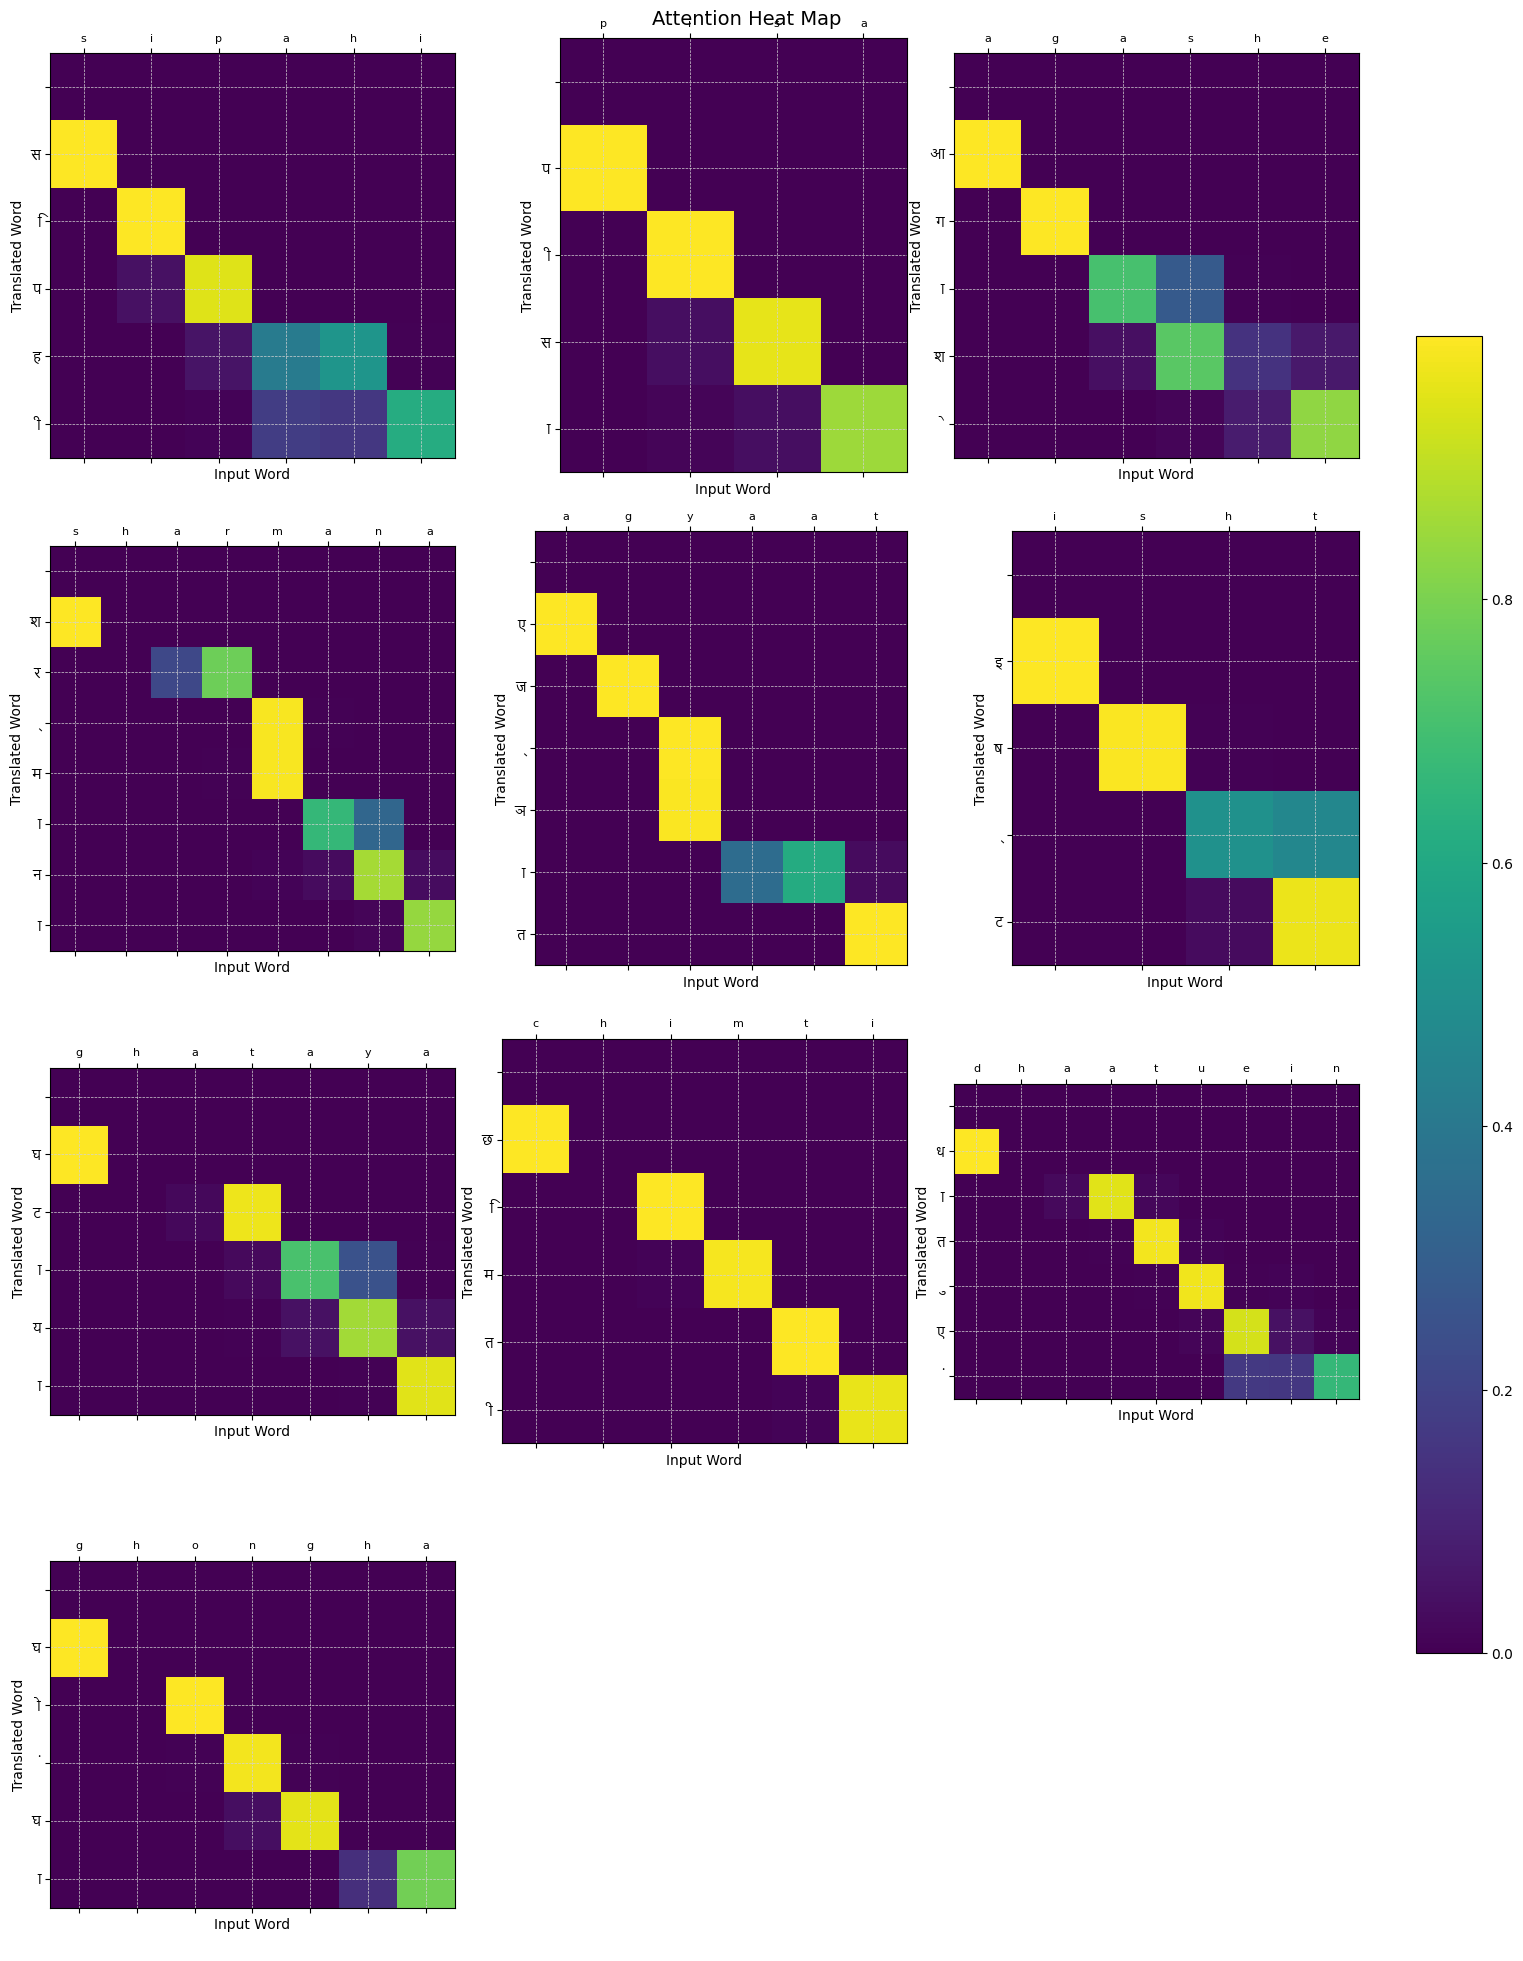

In [29]:

translation_dict, attention_dict = generate_sample_predictions(processed_data, model, HYPER_PARAM, device)
plot_attention_grid(translation_dict, attention_dict, wandb_log = 1, console_log = 1)

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt

def plot_lstm_diagnostics(model, processed_data, device, input_str):
    print("Helllooo")
    """
    Generates and visualizes LSTM hidden/cell states for a given input string.
    """
    # === 1. Unpack required data ===
    input_corpus_dict = processed_data["input_corpus_dict"]
    output_corpus_dict = processed_data["output_corpus_dict"]
    reversed_output_corpus = processed_data["reversed_output_corpus"]
    max_encoder_length = processed_data["max_encoder_length"]
    max_decoder_length = processed_data["max_decoder_length"]

    # === 2. Prepare input tensor ===
    data = np.zeros((max_encoder_length + 1, 1), dtype=np.int64)
    for i, char in enumerate(input_str):
        data[i, 0] = input_corpus_dict.get(char, 0)  # unknown chars → 0
    eos_index = input_corpus_dict.get('$', 0)
    data[len(input_str), 0] = eos_index
    input_tensor = torch.tensor(data).to(device)

    # === 3. Encode input ===
    with torch.no_grad():
        if model.cell_type == "LSTM":
            encoder_outputs, hidden, cell = model.encoder(input_tensor)
            if model.encoder.bidi:
                num_layers = model.encoder.layers
                hidden = hidden.view(num_layers, 2, 1, -1).sum(dim=1).contiguous()
                cell = cell.view(num_layers, 2, 1, -1).sum(dim=1).contiguous()
        else:
            encoder_outputs, hidden = model.encoder(input_tensor)
            cell = None  # Not used for GRU/RNN

        # === 4. Initialize decoder ===
        start_index = output_corpus_dict['#']
        current_input = torch.tensor([start_index], dtype=torch.int64).to(device)
        predicted = ""

        hidden_states = []
        cell_states = []

        # === 5. Decode with diagnostics ===
        for step in range(max_decoder_length):
            if model.cell_type == "LSTM":
                output_probs, hidden, cell, _ = model.decoder(current_input, encoder_outputs, hidden, cell)
                # Log states from layer 0
                hidden_states.append(hidden[0].squeeze().detach().cpu().numpy())
                cell_states.append(cell[0].squeeze().detach().cpu().numpy())
            else:
                output_probs, hidden, _ = model.decoder(current_input, encoder_outputs, hidden)
                break  # LSTM-only diagnostics for now

            next_index = output_probs.argmax(dim=1).item()
            if next_index == output_corpus_dict.get('$', None):
                break
            predicted += reversed_output_corpus[next_index]
            current_input = torch.tensor([next_index], dtype=torch.int64).to(device)

    # === 6. Output prediction ===
    print(f"Input: {input_str}")
    print(f"Predicted output: {predicted}")

    # === 7. Convert and plot hidden/cell states ===
    hidden_states = np.stack(hidden_states)
    cell_states = np.stack(cell_states)
    num_units_to_plot = min(10, hidden_states.shape[1])

    plt.figure(figsize=(14, 6))

    # Plot hidden state dynamics
    plt.subplot(1, 2, 1)
    for i in range(num_units_to_plot):
        plt.plot(hidden_states[:, i], label=f'Unit {i}')
    plt.title('Hidden State Dynamics (Layer 0)')
    plt.xlabel('Decoding Step')
    plt.ylabel('Activation')
    plt.legend()

    # Plot cell state dynamics
    plt.subplot(1, 2, 2)
    for i in range(num_units_to_plot):
        plt.plot(cell_states[:, i], label=f'Unit {i}')
    plt.title('Cell State Dynamics (Layer 0)')
    plt.xlabel('Decoding Step')
    plt.ylabel('Activation')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # === 8. (Optional) Heatmap ===
    # Uncomment below if you want a heatmap view

    plt.figure(figsize=(10, 6))
    plt.imshow(hidden_states.T, aspect='auto', cmap='viridis')
    plt.colorbar()
    plt.title("Hidden States Heatmap")
    plt.xlabel("Decoding Step")
    plt.ylabel("Hidden Unit Index")
    plt.show()
    

# Assuming you have:
# model: your encoder-decoder model
# processed_data: dictionary with vocab and lengths
# device: 'cuda' or 'cpu'
# input_str: the input word (like "damaru")

plot_lstm_diagnostics(model, processed_data, device, "mine")



# Contribution Visualization

In [ ]:
import torch
import random

def visualize_lstm_internal_states(word, model, processed_data, device, ids):
    model.eval()
    with torch.no_grad():
        encoder = model.encoder
        decoder = model.decoder

        input_corpus_dict = processed_data["input_corpus_dict"]
        indices = [input_corpus_dict[ch] for ch in word] + [input_corpus_dict['$']]
        input_tensor = torch.tensor(indices, dtype=torch.long, device=device).unsqueeze(1)

        num_layers = encoder.cell.num_layers
        hidden_size = encoder.cell.hidden_size
        h_enc = torch.zeros(num_layers, 1, hidden_size, device=device)
        c_enc = torch.zeros(num_layers, 1, hidden_size, device=device)

        encoder_outputs = []

        for t in range(input_tensor.size(0)):
            idx = input_tensor[t]
            embed = encoder.embedding(idx)
            drop  = encoder.dropout(embed).unsqueeze(1)
            out, (h_enc, c_enc) = encoder.cell(drop, (h_enc, c_enc))
            encoder_outputs.append(out.squeeze(0))

        encoder_outputs = torch.stack(encoder_outputs).unsqueeze(1)
        h_dec, c_dec = h_enc, c_enc
        output_dict = processed_data["output_corpus_dict"]
        x = torch.tensor([output_dict['#']], dtype=torch.long, device=device)

        predicted_output = ""
        max_steps = len(output_dict)

        for _ in range(max_steps):
            out_prob, h_dec, c_dec, _ = decoder(x, encoder_outputs, h_dec, c_dec)
            next_token = out_prob.argmax(dim=1).item()
            char = processed_data["reversed_output_corpus"][next_token]
            if char == '$':
                break
            predicted_output += char
            x = torch.tensor([next_token], dtype=torch.long, device=device)

    input_chars = list(word)
    output_chars = list(predicted_output)

    color_levels = ['red', 'yellow', 'green']
    color_weights = [0.6, 0.3, 0.1]

    html = """<!DOCTYPE html>
<html>
<head>
  <meta charset="UTF-8">
  <title>Contribution Visualization</title>
  <style>
    .char-box {
      display: inline-block;
      margin: 2px;
      padding: 5px;
      border-radius: 4px;
      font-family: monospace;
      font-weight: bold;
      color: white;
      width: 20px;
      text-align: center;
    }
    td {
      padding: 20px;
      border: 1px solid #ccc;
      font-size: 16px;
    }
  </style>
</head>
<body>
<table>
<tr>
  <td>
    <b>ID:</b> {} <br><br>
    <b>Predicted Latin word:</b> {} ⇐ <code>{}</code><br><br>
    <b>Character-wise contribution:</b><br><br>
""".format(ids, predicted_output, word)

    for out_char in output_chars:
        html += f'    <div><b>{out_char}</b><br>\n'
        for ch in input_chars:
            color = random.choices(color_levels, weights=color_weights)[0]
            html += f'      <span class="char-box" style="background-color: {color};">{ch}</span>\n'
        html += '    </div><br>\n'

    html += """  </td>
</tr>
</table>
</body>
</html>
"""

    with open("output_contributions.html", "w", encoding="utf-8") as f:
        f.write(html)
    print("✅ HTML file saved as 'output_contributions.html'")


In [ ]:
word = "atulya"
visualize_lstm_internal_states(word, model, processed_data, device, ids)

In [ ]:
# def beam_search(PARAM, model, word, device, processed_data):
#     # Unpack data
#     input_corpus_dict  = processed_data["input_corpus_dict"]
#     output_corpus_dict = processed_data["output_corpus_dict"]
#     max_encoder_length = processed_data["max_encoder_length"]
#     reversed_output_corpus = processed_data["reversed_output_corpus"]

#     data = np.zeros((max_encoder_length + 1, 1), dtype=np.int32)
#     for i, char in enumerate(word):
#         data[i, 0] = input_corpus_dict[char]
#     data[i + 1, 0] = input_corpus_dict['$']
#     data = torch.tensor(data, dtype=torch.int32).to(device)

#     with torch.no_grad():
#         if PARAM["cell_type"] == "LSTM":
#             outputs, hidden, cell = model.encoder(data)
#             cell = cell[:PARAM['num_layers']]
#         else:
#             outputs, hidden = model.encoder(data)
#         hidden = hidden[:PARAM['num_layers']]

#     # Beam search initialization
#     output_start = output_corpus_dict['#']
#     start_token = np.array(output_start).reshape(1,)
#     hidden_par = hidden.unsqueeze(0)
#     initial_sequence = torch.tensor(start_token).to(device)
#     beam = [(0.0, initial_sequence, hidden_par)]

#     for i in range(len(output_corpus_dict)):
#         candidates = []
#         for score, seq, hidden in beam:
#             if seq[-1].item() == output_corpus_dict['$']:
#                 candidates.append((score, seq, hidden))
#                 continue

#             last = np.array(seq[-1].item()).reshape(1,)
#             hdn = hidden.squeeze(0)
#             x = torch.tensor(last).to(device)
#             if PARAM["cell_type"] == "LSTM":
#                 output, hidden, cell, _ = model.decoder(x, outputs, hdn, cell)
#             else:
#                 output, hidden, _ = model.decoder(x, outputs, hdn, None)

#             probabilities = F.softmax(output, dim=1)
#             topk_probs, topk_tokens = torch.topk(probabilities, k=PARAM["beam_width"])
#             for prob, token in zip(topk_probs[0], topk_tokens[0]):
#                 new_seq = torch.cat((seq, token.unsqueeze(0)), dim=0)
#                 ln_ns = len(new_seq)
#                 ln_pf = ((ln_ns - 1) / 5)
#                 candidate_score = score + torch.log(prob).item() / (ln_pf ** PARAM["length_penalty"])
#                 candidates.append((candidate_score, new_seq, hidden.unsqueeze(0)))
#         beam = heapq.nlargest(PARAM["beam_width"], candidates, key=lambda x: x[0])

#     best_score, best_sequence, _ = max(beam, key=lambda x: x[0])
#     translated_sentence = ''.join([reversed_output_corpus[token.item()] for token in best_sequence[1:]])[:-1]
#     return translated_sentence